[View in Colaboratory](https://colab.research.google.com/github/zacateras/nn-nbirds/blob/master/report_colab.ipynb)

Michał Sitko \
Michał Chmielowiec \
Andrzej Dawidziuk \

# Neural Networks (SNR) 2018L - Preliminary Report


---


We decided to use [Google Collaboratory](https://colab.research.google.com) as a main platform for project development. So called Colab was developed by Google internally from year 2014 as a tool dedicated for machine learning reaserch. Now it is publicly available as a side Google Drive service.

Colab is an online version of Jupyter Notebook - a web application that allows its users to create and share documents that contain live code, equations, visualizations and narrative text. Usually Jupyter Notebooks are hosted locally on researchers' machines. Very often these machines are not equipped with processing units suited for complex calculations. Locally prepared Jupyter reports are printed as PDF documents and then statically distributed.

Google Colab provides online version of Jupyter server with exposed by very convenient web interface. Each Google Drive account is allowed to use one Jupyter Notebook environment. Technically, environments are setup inside cloud hosted, UNIX type, Docker containers. The containers' virtual hard drives can expand to the maximum space available for particular account in its Google Drive service. Furthermore the container environment has access to pretty powerful computing resources: quad core CPU and Tesla K80 GPU. We should note here that those resources are shared by multiple users and thus its base performance may vary.

This report was prepared in Colab.

Let's ensure that the installed Python version is at least 3.6. It happens occasionally that containers are initialized with Python 2.7 kernels despite the fact that they are the higher is configured. In such situation the hypervisor should be rebooted (i.e. by invoking a kill command).

In [1]:
# If python3 is not loaded kill the hypervisor
# ! kill -9 -1
import sys
sys.version

'3.6.3 (default, Oct  3 2017, 21:45:48) \n[GCC 7.2.0]'

Now we will clone the project repository and install required pip packages. Interactive shell can be accessed inline by prefixing commands with an exclamation mark (!).

In [2]:
% cd ~

# Remove the environment
! if [ -d "nn-nbirds" ]; then rm -rf "nn-nbirds"; fi
# ! pip freeze | xargs pip uninstall -y

# Build the environment 
! git clone https://github.com/zacateras/nn-nbirds.git
% cd ./nn-nbirds
! pip install -r requirements.txt > pip.log
# Those below fixes the issue with keras @ Colab
! pip install Pillow==4.0.0 -q
! pip install PIL -q
! pip install image -q

/content
Cloning into 'nn-nbirds'...
remote: Counting objects: 90, done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 90 (delta 44), reused 61 (delta 22), pack-reused 0
Unpacking objects: 100% (90/90), done.
/content/nn-nbirds
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


The whole nbirds database was stored in dropbox as a zip blob. We prepared automated shell script for downloading and unzipping it. Let's use it now.

In [3]:
# Download the dataset
! ./download.sh

--2018-04-27 21:57:30--  https://www.dropbox.com/s/fi2g3zxsn0pdmn1/nbirds.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:6022:1::a27d:4201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/QNQw0sdwaubYwbUc3BkpoHQZlN2U0D0jSqNDVPkJkRoyxFrQ7FIBMSSlyugEGIDU/file [following]
--2018-04-27 21:57:30--  https://dl.dropboxusercontent.com/content_link/QNQw0sdwaubYwbUc3BkpoHQZlN2U0D0jSqNDVPkJkRoyxFrQ7FIBMSSlyugEGIDU/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.8.6, 2620:100:601f:6::a27d:906
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.8.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 623160299 (594M) [application/zip]
Saving to: ‘/content/nn-nbirds/data/nbirds.zip’

/content/nn-nbirds/ 100%[===================>] 594.29M  32.3MB/s    in 19s     



Colab runtime can provide stable and fast internet connection. ~45MB/s average download speed should be noted here.

## Database analysis
Dostarczona baza danych zawiera 48562 zdjęć ptaków należących do 555 klas (gatunków). Rozkład liczby zdjęć należących do poszczególnych klas przedstawia Wykres 1. Puste miejsca na histogramie świadczą o większej ilości klas niż wynika to ze zbioru zdjęć, co zostało wyjaśnione niżej. \



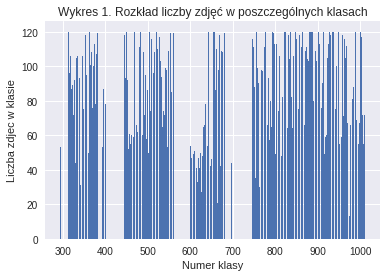

In [4]:
import matplotlib.pyplot as plt
import numpy as np
#show database content chart

data = np.genfromtxt('data/image_class_labels.txt', delimiter=' ', usecols = (1),
                    dtype=int)
          
unique, counts = np.unique(data, return_counts=True)
plt.bar(unique, counts)
plt.ylabel('Liczba zdjec w klasie')
plt.xlabel('Numer klasy')
plt.title('Wykres 1. Rozkład liczby zdjęć w poszczególnych klasach')
plt.show()

Ponieważ poszczególne klasy odpowiadają konkretnym gatunkom ptaków, możliwym było zbudowanie hierarchii klas przypominającej biologiczną systematykę organizmów. Taka hierarchia została dostarczona wraz z bazą, a jej drzewo w formie graficznej przedstawia wygenerowany w trakcie prac nad projektem obraz w formacie SVG dostępny w postaci poniższego linku: \
[Hierarchia klas ptaków](http://mion.elka.pw.edu.pl/~mchmielo/tmp/nbirds_hierarchy.svg) \
Wszystkich klas w hierarchii jest 1011. Oprócz informacji na temat przynależności zdjęć do poszczególnych klas oraz samej hierarchii klas, baza dostarcza informacje na temat Autorów oraz rozmiarów zdjęć. Ważną informacją zawartą w bazie są rozmiary *bounding box* czyli rozmiarów najmniejszych prostokątów w których zawarte są w całości obiekty będące przedstawicielami poszczególnych gatunków ptaków na badanych zdjęciach. Pozwoliło to znacznie ograniczyć rozmiar danych do klasyfikatora. Nazwy plików graficznych są powiązane z wyżej opisanymi danymi za pomocą unikalnych identyfikatorów *image_guid*. Zależności pomiędzy plikami bazy dobrze odzwierciedla Diagram 1. \
 \
**Diagram 1** Wizualizacja powiązań plików bazy danych ![Diagram 1](https://raw.githubusercontent.com/zacateras/nn-nbirds/master/assets/dataset.png) \

Now we will load our script for metadata loading & dataset preprocessing.

In [0]:
from preprocess import *

In [6]:
ds_meta = build_ds_meta()

for ds_meta_item in ds_meta:
    print('Quantity of %s: %s' % (ds_meta_item, ds_meta[ds_meta_item].count()[0]))

Quantity of bounding_boxes: 48562
Quantity of classes: 1011
Quantity of hierarchy: 1010
Quantity of image_class_labels: 48562
Quantity of images: 48562
Quantity of photographers: 48562
Quantity of sizes: 48562


In order to prepare dataset images library for feature extraction we shall apply a few transformations. Let's define and execute them here. All pictures will be cropped with bounding boxes defined in metadata, resized to 150 / 150 dimensions, converted to grayscale and transformed with Gabor filter. Hyperparameters of the filter were adjusted, so that different color and contrast bounderies are exposed. New images will be copied to the separate folder, after then the whole dataset will be divided into train, cross-validation and test parts in (0.7 / 0.2 / 0.1 proportion).

In [0]:
class Transform:
  def __init__(self, img, guid, ds_meta):
    self.img = img
    self.guid = guid
    self.ds_meta = ds_meta
  
  def resize(self):
      img = cv2.resize(self.img, (150, 150))
      return self

  def greyscale(self):
      img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
      return self

  def gabor_filter(self):
      g_kernel = cv2.getGaborKernel((15, 15), 0.66, np.pi/8, 1.3, 0.5, 0, ktype=cv2.CV_32F)

      img = cv2.normalize(cv2.filter2D(self.img, cv2.CV_8UC3, g_kernel),
                           None,
                           alpha=0,
                           beta=255,
                           norm_type=cv2.NORM_MINMAX,
                           dtype=cv2.CV_32F)
      
      return self

# BASE               SET_A
# + Bounding box  => SET_A_BB               (del)
# + Gabor filter  => SET_A_BB_GF            (del)
# + TVT splitting => SET_A_BB_GF_train
#                    SET_A_BB_GF_validation
#                    SET_A_BB_GF_test

apply(bounding_box, 'data/SET_A', 'data/SET_A_BB', ds_meta)
apply(lambda img, guid, dsm: Transform(img, guid, ds_meta).resize().greyscale().gabor_filter().img, 'data/SET_A_BB', 'data/SET_A_BB_GF', ds_meta)
apply_tvt_split('data/SET_A_BB_GF', train=0.7, test=0.2, validation=0.1)

Example images before and after transformation are presented below:

![](https://raw.githubusercontent.com/zacateras/nn-nbirds/master/assets/sample_before.jpg =320x220) ![](https://raw.githubusercontent.com/zacateras/nn-nbirds/master/assets/sample_after.jpg =220x220)

For building the model we will use Keras library. It is a high level deep neural network modeling toolset. It enables professionals to quickly prototype and train very complex networks, also it provides a rich set of functionalities for input data preprocessing, result model validation and many other. We will try to show a few of those functionalities in this report (and its continuation).

Keras can run on top of different low level machine learning frameworks such as [TensorFlow](https://www.tensorflow.org/), [CNTK](https://docs.microsoft.com/pl-pl/cognitive-toolkit/), [Theano](http://www.deeplearning.net/software/theano/). We will stick to the most popular one with the most mature community.

In [8]:
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


GPU device is available!

In [9]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

By calling appropriate backend methods we can get some more specific info concerning processing devices that are available.

In [10]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3488870340712929096, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11288962663
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13989086740330256603
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
batch_size = 32

train_labels = os.listdir('data/SET_A_BB_GF_train')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/SET_A_BB_GF_train',
    target_size=(150, 150),
    batch_size=batch_size,
    color_mode='grayscale')

validation_generator = train_datagen.flow_from_directory(
    'data/SET_A_BB_GF_validation',
    target_size=(150, 150),
    batch_size=batch_size,
    color_mode='grayscale')

model = Sequential()
model.add(Flatten(input_shape=(150, 150, 1))) 
model.add(Dense(4))
model.add(Dense(8))
model.add(Dense(len(train_labels)))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=20)

Found 2103 images belonging to 50 classes.
Found 300 images belonging to 50 classes.
Epoch 1/50
62/62 [==============================] - 19s 301ms/step - loss: 4.0976 - acc: 0.0131 - val_loss: 4.0922 - val_acc: 0.0267
Epoch 2/50
62/62 [==============================] - 18s 295ms/step - loss: 4.0191 - acc: 0.0214 - val_loss: 3.9231 - val_acc: 0.0317
Epoch 3/50
62/62 [==============================] - 18s 284ms/step - loss: 3.9644 - acc: 0.0307 - val_loss: 3.9642 - val_acc: 0.0183
Epoch 4/50
62/62 [==============================] - 17s 273ms/step - loss: 4.0288 - acc: 0.0151 - val_loss: 3.8990 - val_acc: 0.0217
Epoch 5/50
29/62 [=============>................] - ETA: 4s - loss: 3.9001 - acc: 0.0312

62/62 [==============================] - 17s 278ms/step - loss: 3.9264 - acc: 0.0267 - val_loss: 3.8858 - val_acc: 0.0267
Epoch 6/50
62/62 [==============================] - 17s 274ms/step - loss: 3.8777 - acc: 0.0292 - val_loss: 3.8539 - val_acc: 0.0267
Epoch 7/50
62/62 [==============================] - 17s 279ms/step - loss: 3.8429 - acc: 0.0358 - val_loss: 3.9033 - val_acc: 0.0250
Epoch 8/50
62/62 [==============================] - 17s 275ms/step - loss: 3.8656 - acc: 0.0328 - val_loss: 3.8316 - val_acc: 0.0333
Epoch 9/50
62/62 [==============================] - 17s 273ms/step - loss: 3.8292 - acc: 0.0393 - val_loss: 3.8416 - val_acc: 0.0383
Epoch 10/50
18/62 [=======>......................] - ETA: 4s - loss: 3.8102 - acc: 0.0399

62/62 [==============================] - 17s 278ms/step - loss: 3.8207 - acc: 0.0388 - val_loss: 3.8232 - val_acc: 0.0183
Epoch 11/50
60/62 [============================>.] - ETA: 0s - loss: 3.8490 - acc: 0.0408

## References

#### Google Colab
* [Colab Teaser](https://hackernoon.com/train-your-machine-learning-models-on-googles-gpus-for-free-forever-a41bd309d6ad)
* [Simple Colab Example](https://towardsdatascience.com/fast-ai-lesson-1-on-google-colab-free-gpu-d2af89f53604)
* [Extensive Colab Example](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)

#### Gabor Filters
* [Practical overview of Gabor Filters](https://cvtuts.wordpress.com/2014/04/27/gabor-filters-a-practical-overview/)
* [Library for testing various filter configurations](http://nbviewer.jupyter.org/github/bicv/LogGabor/blob/master/LogGabor.ipynb)
* [Example of applying OpenCV implementation in Python](https://gist.github.com/kendricktan/93f0da88d0b25087d751ed2244cf770c)
* [Feature extraction in face recognition task](https://pdfs.semanticscholar.org/3cf9/e4bc906ee4d15b69b34db413f8e319692e3b.pdf)
* [Feature extraction in car recognition task](http://scholar.google.pl/scholar_url?url=http://www.academia.edu/download/3448045/Car_recognition_using_gabor_filter_feature_extraction.doc&hl=pl&sa=X&scisig=AAGBfm2C3mPP89cH7bXDsFiXMDNPLIY27Q&nossl=1&oi=scholarr&ved=0ahUKEwizv5bdgdTaAhXEGuwKHXy-AY0QgAMIKSgCMAA)

#### DNNs in Keras
* [Keras documentation](https://keras.io/)